# Predicting Customer Churn Risk and Future Purchases

Lebih efektif secara biaya untuk mempertahankan pelanggan yang sudah ada daripada mengakuisisi yang baru, oleh karena itu penting untuk melacak pelanggan yang berisiko tinggi untuk berhenti (churn) dan menargetkan mereka dengan strategi retensi.

Tujuan utama dari pekerjaan ini adalah membangun model probabilistik untuk meramalkan nilai seumur hidup pelanggan (Pembelian Mendatang) dan risiko berhenti pelanggan dalam pengaturan non-kontraktual pada tingkat individu.

Model probabilitas yang akan saya gunakan adalah model BG/NBD dari paket Lifetimes.
- Membedakan pelanggan aktif dari pelanggan tidak aktif.
- Menghasilkan ramalan transaksi untuk pelanggan individu.
- Memprediksi volume pembelian dari seluruh basis pelanggan.
- Memprediksi risiko berhenti pelanggan.hurn risk


In [16]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
import matplotlib as mpl
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.rc('font', family='Calibri')
mpl.rc('axes', unicode_minus=False)

orders = pd.read_csv('data/olist_orders_dataset.csv')
items = pd.read_csv('data/olist_order_items_dataset.csv')
cust = pd.read_csv('data/olist_customers_dataset.csv')

### Data Cleaning

In [4]:
print(cust.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


In [5]:
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64

Mayoritas customer hanya melakukan sekali pembelian.

In [6]:
orders = pd.merge(orders,cust[['customer_id','customer_unique_id']],on='customer_id')
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id'],
      dtype='object')

In [7]:
print(items.columns)

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


In [8]:
items.drop_duplicates('order_id',keep='first',inplace=True)

In [9]:
transaction_data = pd.merge(orders,items,'inner','order_id')
transaction_data = transaction_data[['customer_unique_id','order_purchase_timestamp','price']]
# convert timestamp to date
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()

,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


In [10]:
summary = summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price',)
summary.describe()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


In [11]:
summary.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0


In [12]:
summary[summary['frequency']>0].head(10)

,frequency,recency,T,monetary_value
customer_unique_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90
011b4adcd54683b480c4d841250a987f,1.0,177.0,377.0,56.97
012452d40dafae4df401bced74cdb490,1.0,330.0,442.0,330.00
012a218df8995d3ec3bb221828360c86,1.0,42.0,119.0,1369.90
013ef03e0f3f408dd9bf555e4edcdc0a,1.0,29.0,74.0,59.90


In [13]:
transaction_data[transaction_data['customer_unique_id']=='004288347e5e88a27ded2bb23747066c']


,customer_unique_id,price,date
33396,004288347e5e88a27ded2bb23747066c,229.99,2017-07-27
39730,004288347e5e88a27ded2bb23747066c,87.90,2018-01-14


### Visualizing the RFM DataFrame

In [14]:
bgf = BetaGeoFitter(penalizer_coef=0.00)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

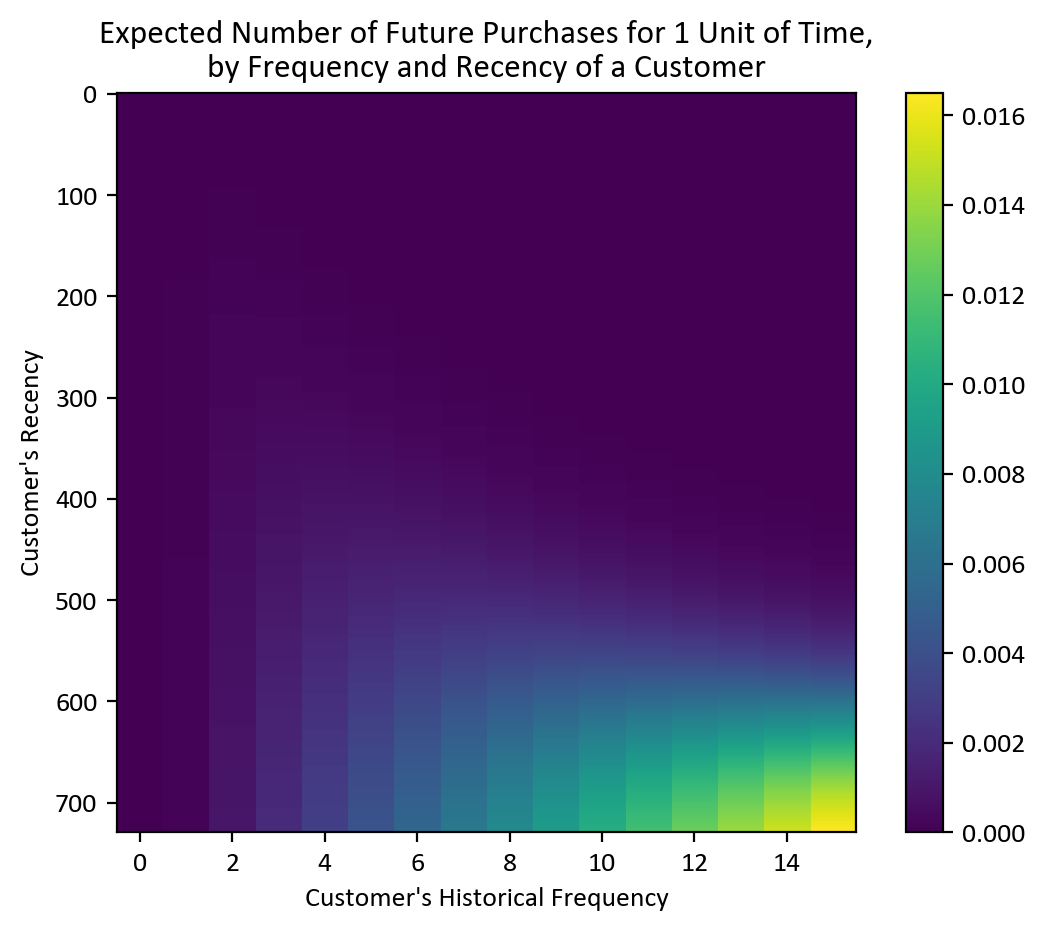

In [17]:
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

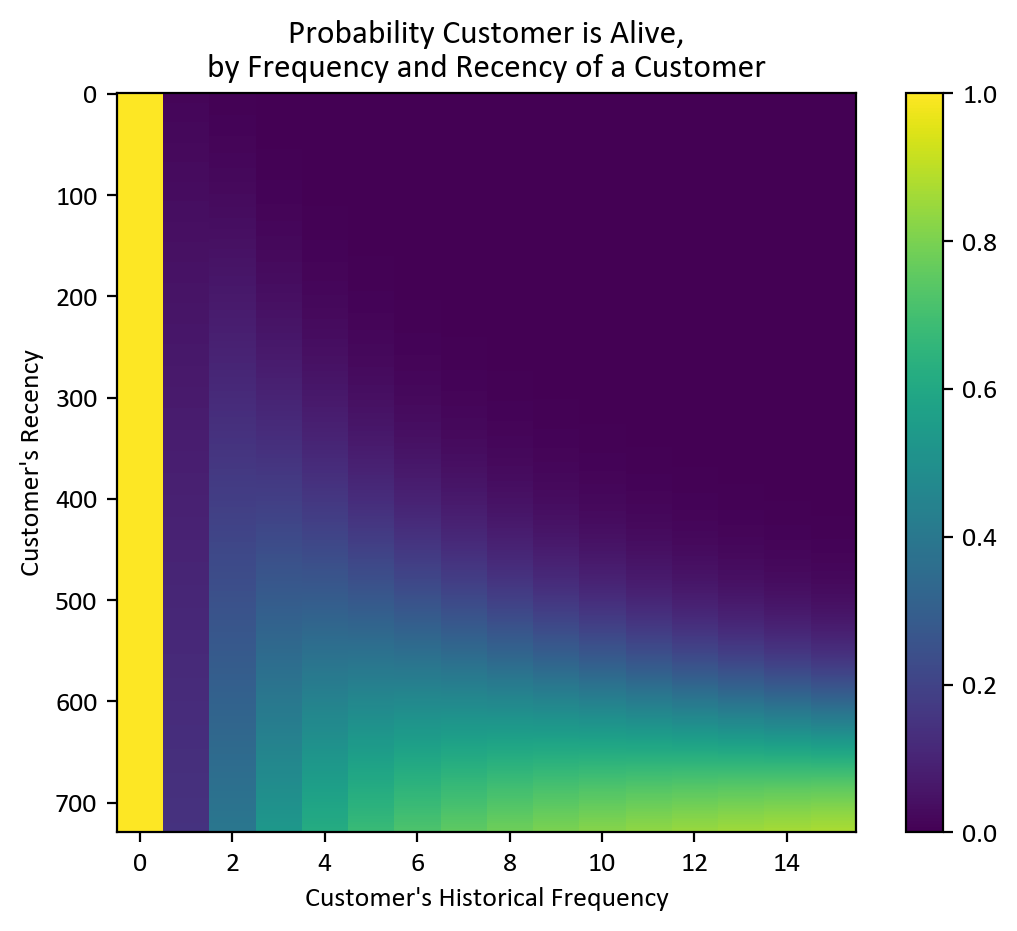

In [18]:
plot_probability_alive_matrix(bgf)

## Modeling Future Purchases(Life Time Value)

- Histogram periode kalibrasi: apakah model cocok dengan data latihan?
- Plot transaksi kumulatif: apakah model memprediksi penjualan kumulatif dengan baik?
- Plot transaksi inkremental: apakah model menangkap tren keseluruhan dalam transaksi?
- Plot ekspektasi bersyarat: dapatkah model memprediksi jumlah pembelian yang akan dilakukan oleh pelanggan berdasarkan data latihan? n? 

### 1) Calibration period histogram

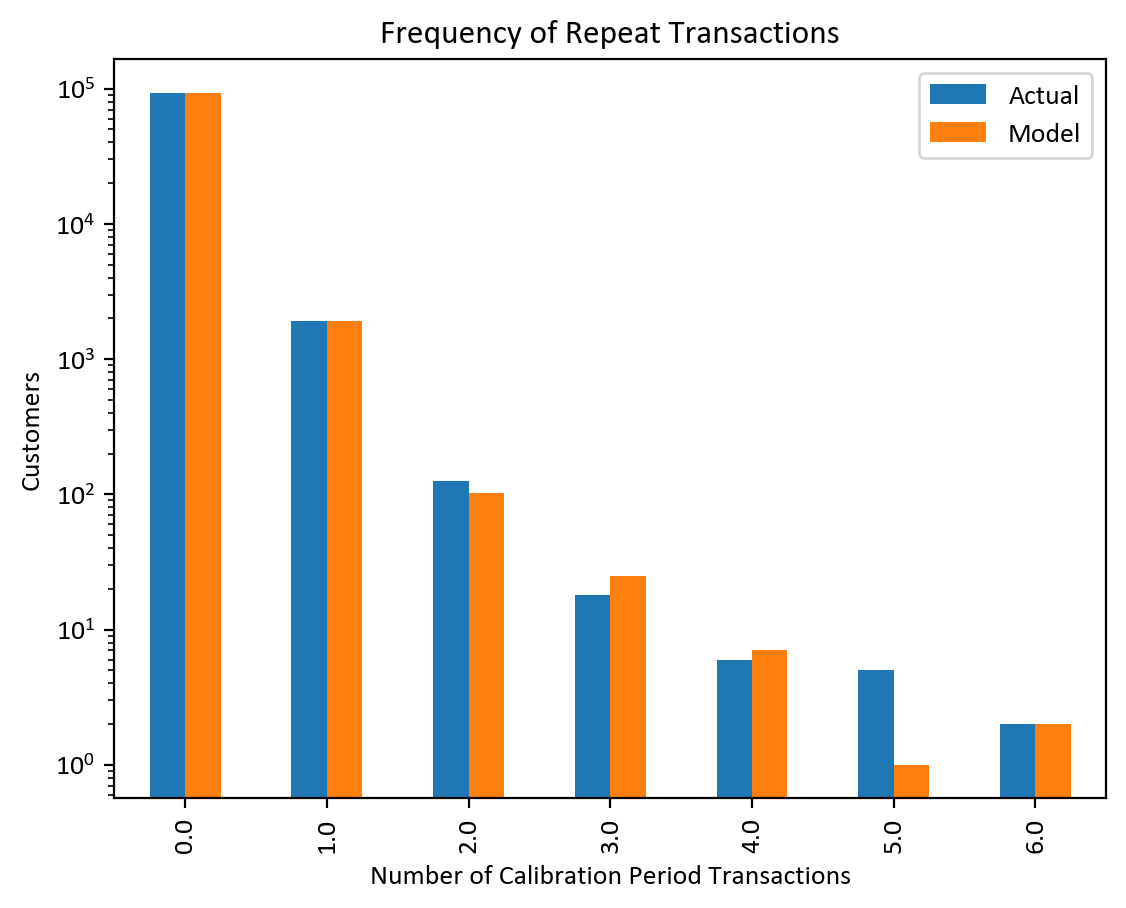

In [20]:
plot_period_transactions(bgf).set_yscale('log')

Dapat terlihat bahwa data aktual dan data simulasi sejalan dengan baik. Model ini cukup mewakili data nyata hingga lima transaksi ulang. Ada sedikit pelanggan yang melakukan lebih banyak pembelian.

### 2) Cumulative transaction plot

In [21]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_unique_id', 'date',calibration_period_end='2017-09-03', observation_period_end='2018-09-03' )



<Axes: title={'center': 'Tracking Cumulative Transactions'}, xlabel='day', ylabel='Cumulative Transactions'>

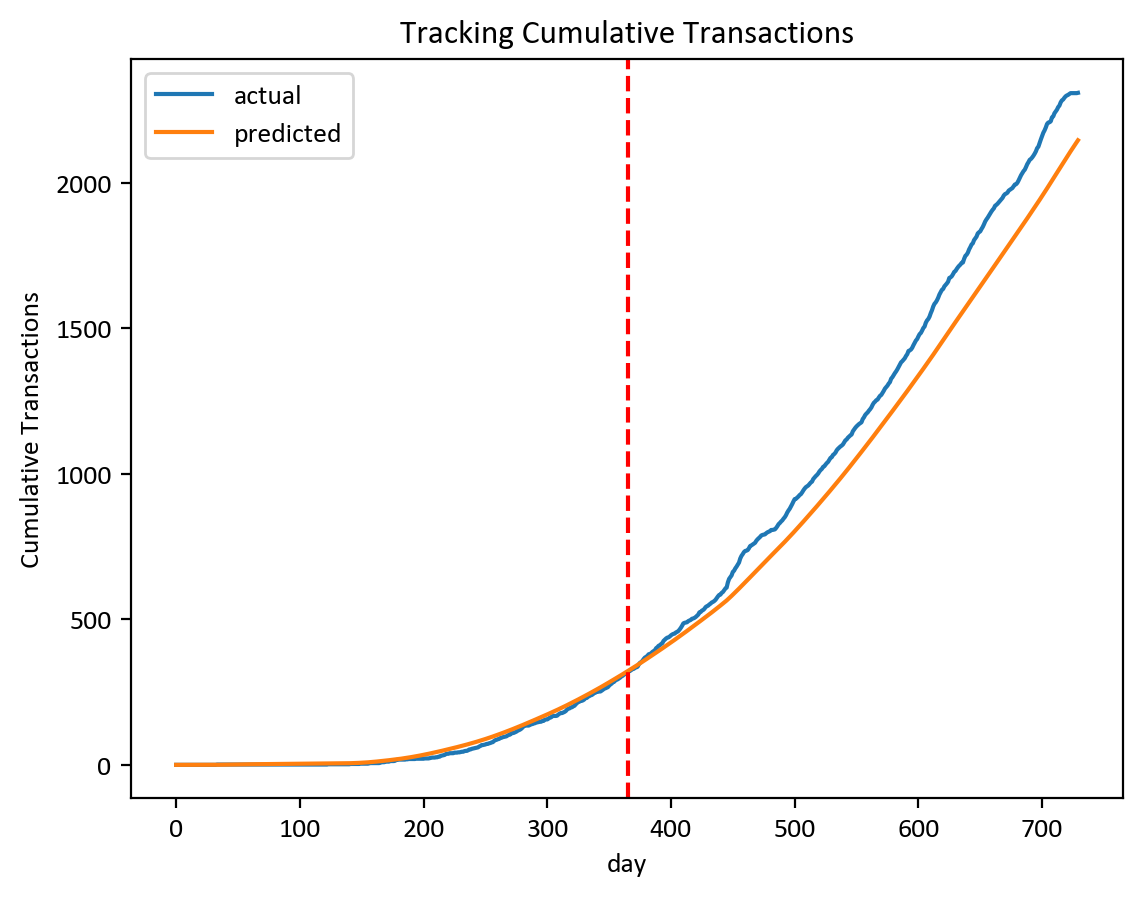

In [22]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 730, 365)

Garis merah mewakili batas antara periode kalibrasi di sebelah kiri dan periode penahanan di sebelah kanan. Seperti yang dapat Anda lihat, model BG/NBD bagus dalam memprediksi transaksi kumulatif.

### 3) Incremental transaction plot

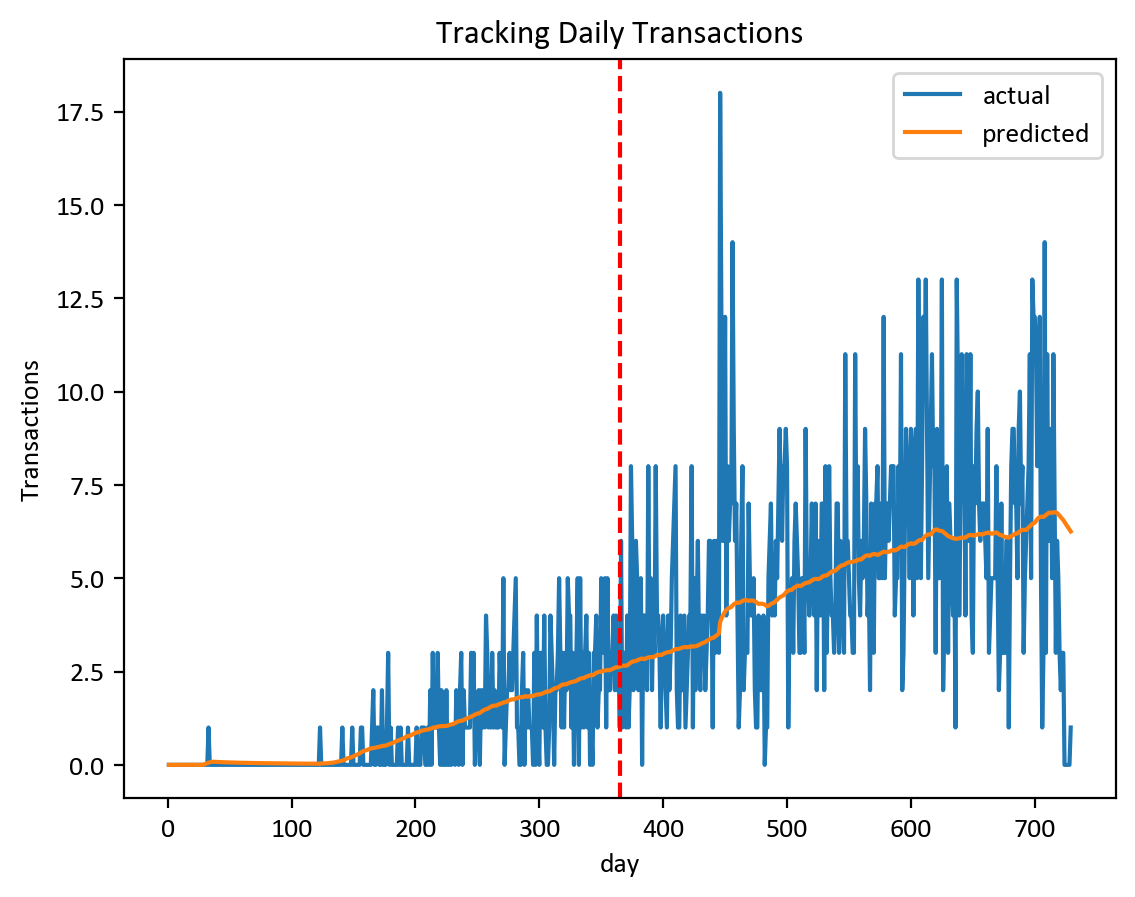

In [23]:
plot_incremental_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 730, 365);


Plot ini menunjukkan bahwa model berhasil menangkap tren umum dalam data.

### 4) Conditional expectations plot

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

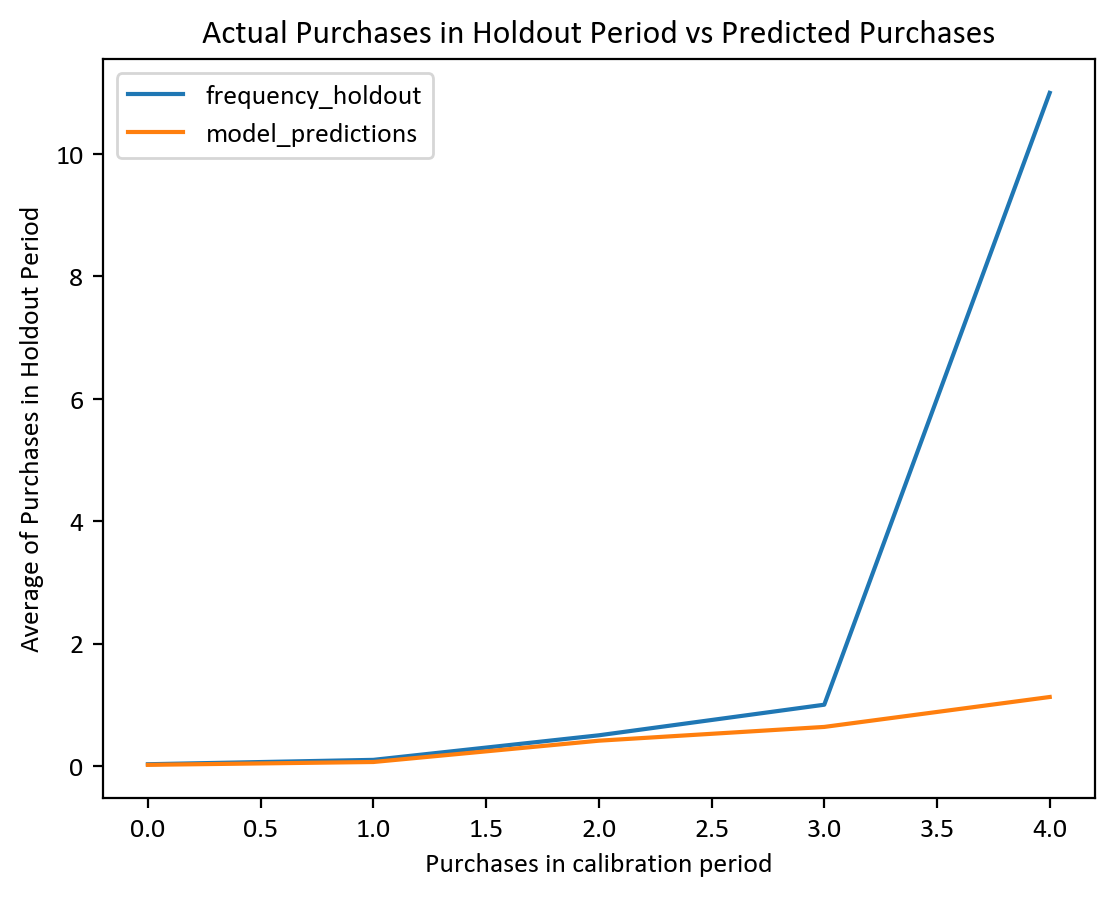

In [24]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

Model ini berperforma baik hingga tiga pembelian dalam periode kalibrasi, tetapi berbeda dari data penahanan karena distribusi data.

In [25]:
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64

Kurang dari 1% dari pelanggan telah melakukan empat atau lebih pembelian, jadi tidak banyak data bagi model BG/NBD untuk mempelajari tentang pelanggan yang telah melakukan banyak transaksi ulang.

## Modeling Churn Risk

Kita hanya akan memprediksi risiko berhenti pada pelanggan yang telah melakukan setidaknya satu transaksi ulang.

<Axes: xlabel='prob_alive', ylabel='Density'>

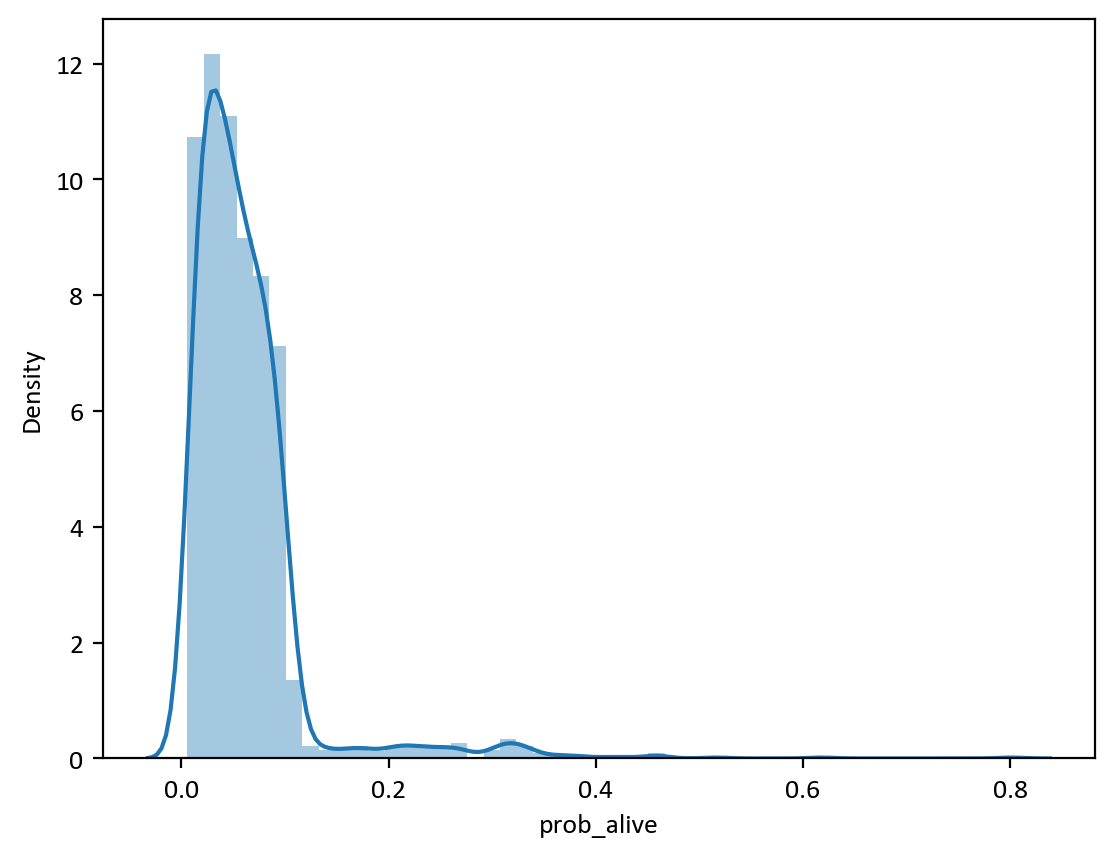

In [26]:
df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive'])

Dengan menggunakan pengetahuan mengenai proses bisnis yang dimiliki, kita mungkin dapat menetapkan ambang batas untuk pelanggan yang kemungkinan sudah berhenti, dan juga mengidentifikasi pelanggan yang berisiko berhenti, tetapi belum menghilang atau berpaling.

Asumsikan pelanggan dengan <10% kemungkinan masih aktif sebagai sudah berhenti.i.


In [27]:
df.head()

,frequency,recency,T,monetary_value,prob_alive
customer_unique_id,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90,0.053200
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00,0.082272
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58,0.033793
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55,0.039748
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90,0.046973


<Axes: xlabel='customer_unique_id', ylabel='count'>

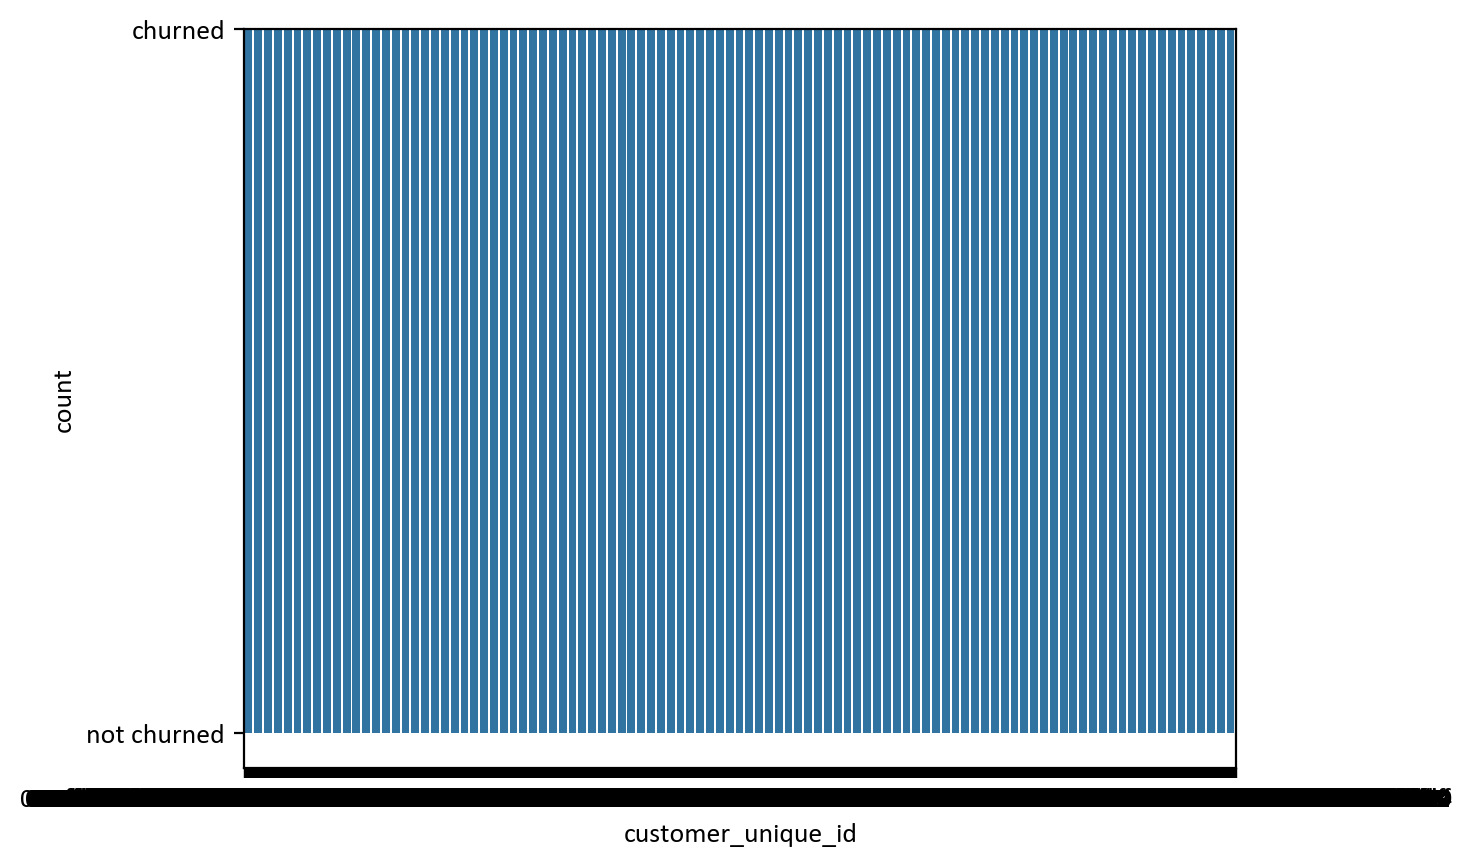

In [28]:
df['churn'] = ['churned' if p < 0.1 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn'])

Sekitar 92% dari pelanggan telah berhenti, artinya ada banyak kesempatan untuk meningkatkan retensi.
Kita dapat mengasumsikan bahwa pelanggan yang telah berhenti sudah hilang.

Mari temukan pelanggan yang berisiko tinggi untuk berhenti, tetapi belum berhenti. Kemudian, mungkin masih merupakan ide yang baik untuk memberikan perlakuan yang berbeda kepada kelompok yang sudah berhenti.oup.

Text(0.5, 1.0, 'Probability alive, not churned')

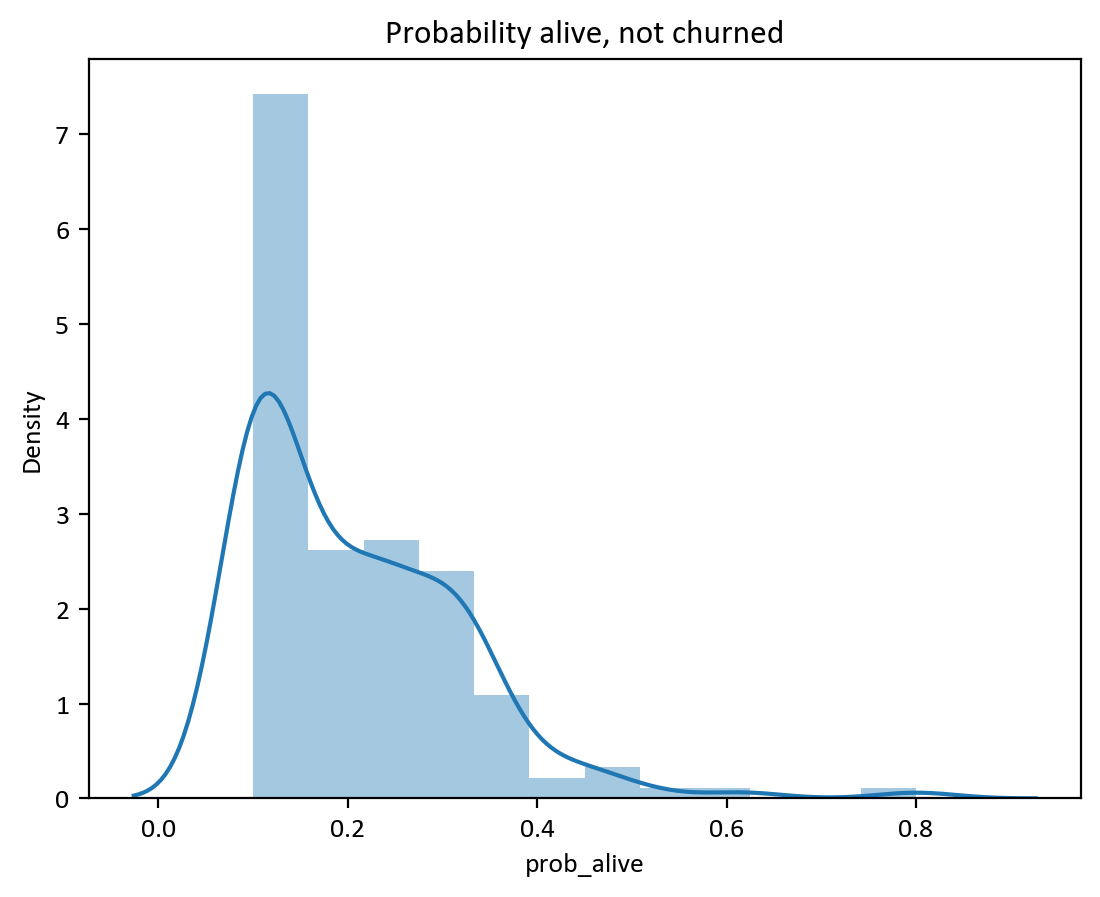

In [29]:
sns.distplot(df[df['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned')

Mengelompokkan pelanggan dengan risiko berhenti 80% atau lebih untuk dianggap sebagai risiko tinggi untuk berhenti tampaknya masuk akal.

In [30]:
df['churn'][(df['prob_alive']>=0.1) & (df['prob_alive']<0.2)] = "high risk"
df['churn'].value_counts()

churn
churned        1928
high risk        84
not churned      73
Name: count, dtype: int64

Now that I have these churn groupings, I can move forward and apply special treatments to these groups. 

- `churned`:        1928
- `high risk`:        84
- `not churned`:      73

## Conclusion


- **Hubungi pelanggan yang sudah berhenti untuk mencari tahu alasan mereka meninggalkan.**
- **Kirim jenis email yang berbeda dan penawaran khusus kepada kelompok risiko tinggi.**
- **Tentukan pelanggan dengan nilai tertinggi di dalam kelompok non-berhenti, dan berikan manfaat tambahan kepada mereka untuk memastikan bahwa mereka tetap menjadi pelanggan setia (VIP).**
**
